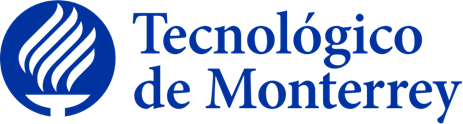

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**

### Dra. Grettel Barceló Alonso
### Dr. Luis Eduardo Falcón Morales
### Mtra. Verónica Sandra Guzmán de Valle

## **Avance 6: Modelo Final**

### Domingo 2 de junio de 2024

## **Nombres y matrículas de los integrantes del Equipo 10:**

* Fernando Maytorena Espinosa de los Monteros | A01110946
* Jonathan Garza Bennet | A01793038
* Rafael José Mateo Comprés | A01793054

#### Note: This notebook is still a work in progress

### 1. First, we load the libraries

In [12]:
from deepeval import evaluate
from deepeval.metrics import AnswerRelevancyMetric, ContextualRecallMetric, HallucinationMetric
from deepeval.test_case import LLMTestCase
from deepeval.dataset import EvaluationDataset
from peft import PeftModel
from unsloth import FastLanguageModel
import json
from dotenv import load_dotenv
from deepeval.synthesizer import Synthesizer
from loader.legal_document_loader import LegalDocumentLoader
import os
import re


### 2. Then we extract the env variables

In [13]:
load_dotenv()

True

In [6]:
url = "https://github.com/rafaeljosem/MNA-ProyectoIntegrador_EQ10/raw/main/Avance-4/mexican_laws"

docs = LegalDocumentLoader.load_from_url(url)
path = './tmp'



In [10]:
if not os.path.exists(path):
    os.makedirs(path)

for doc in docs:
    filename = doc['Title'].encode('ascii', 'ignore')
    filename = filename.decode()
    filename = filename.lower().replace(' ', '_') + '.txt'
    
    with open(os.path.join(path,filename), 'w') as f:
        f.write(doc['Text'])
    



In [ ]:
os.removedirs(path)

In [3]:
synth = Synthesizer( model = 'gpt-3.5-turbo', multithreading = False)

list_docs = []

for path, folders, files in os.walk('./tmp'):
    for file in files[:5]:
        if file.endswith('.txt'):
            list_docs.append(f'./tmp/{file}')

synth.generate_goldens_from_docs(
   
    document_paths=list_docs,
    include_expected_output=True,
    chunk_overlap=50,
    num_evolutions = 1,
    max_goldens_per_document=1)

synth.save_as(file_type='json', directory='./synthetic_data')

Output()

Synthetic goldens saved at ./synthetic_data/20240605_203859.json!


'./synthetic_data/20240605_203859.json'

### 3. Let's download the model that was finetuned 

In [14]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = 2048,
    device_map='cuda',
    load_in_4bit = True,
)


==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: NVIDIA GeForce RTX 4070 Laptop GPU. Max memory: 7.996 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = True.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:

model = PeftModel.from_pretrained(model, model_id='JonathanGarza/unsloth-llama-3-8b-bnb-4bit-Mexican-Federal-Laws-Instruct-FineTuned-v1')

In [16]:
FastLanguageModel.for_inference(model)

### 4. Let's generate a sample prompt from our model 

In [30]:
# alpaca_based_prompt = """A continuación se muestra una instrucción que describe una tarea, junto con una entrada que proporciona más contexto. Escribe una respuesta que complete adecuadamente la solicitud

# ### Instrucción:
# {}

# ### Entrada:
# {}

# ### Respuesta:
# {}"""

In [17]:
with open('./synthetic_data/test_set.json', 'r') as f:
    test_set = json.load(f)
    
test_set[:2]

[{'input': '¿Cómo se relacionan la nacionalidad mexicana, la falta de antecedentes penales y la aptitud física y académica en los criterios de ingreso a la Armada de México?',
  'actual_output': None,
  'expected_output': 'Para ingresar a la Armada de México se requiere ser mexicano por nacimiento, no contar con antecedentes penales por delitos dolosos o intencionales, y reunir los requisitos de aptitud física y académica, además de estar en pleno goce y ejercicio de los derechos civiles y políticos.',
  'context': ['\nIX. Músicos Navales;\n\nX. Sanidad Naval;\n\nFracción reformada DOF 31-12-2012\n\nXI. Trabajo Social Naval, y\n\nFracción reformada DOF 31-12-2012\n\nXII. Otros que sean necesarios a juicio del Alto Mando.\n\nFracción adicionada DOF 31-12-2012\n\nArtículo 47.- Para ingresar a la Armada de México se requiere:\n\nI. Ser mexicano por nacimiento;\n\nII. No contar con otra nacionalidad;\n\nFracción reformada DOF 31-12-2012\n\nIII. Estar en pleno goce y ejercicio de los derech

In [18]:
def extract_response(response: str) -> str|None:
    match = re.search(r"### Respuesta:\n([\s\S]*)", response)
    if match:
        return match.group(1)
    return None
    

In [19]:
def get_test_case(datapoint:dict) -> LLMTestCase:
    input = datapoint.get("input", None)
    actual_output = datapoint.get("actual_output", None)
    expected_output = datapoint.get("expected_output", None)
    context = datapoint.get("context", None)

    return LLMTestCase(
        input=input,
        actual_output=actual_output,
        expected_output=expected_output,
        context=context
    )

In [20]:
alpaca_based_prompt = """A continuación se muestra una instrucción que describe una tarea, junto con una entrada que proporciona más contexto. Escribe una respuesta que complete adecuadamente la solicitud

### Instrucción:
{}

### Entrada:
{}

### Respuesta:
{}"""

In [36]:
test_cases = []
for datapoint in test_set[:10]:
    inputs = tokenizer(
    [
        alpaca_based_prompt.format(
            datapoint['input'], # Instrucción
            "", # Entrada
            "", # Salida - leave this blank for generation!
        )
    ], return_tensors = "pt").to("cuda")

    outputs = model.generate(**inputs, max_new_tokens = 650, use_cache = True, pad_token_id=tokenizer.eos_token_id)
    result = tokenizer.batch_decode(outputs)
    datapoint['actual_output'] = extract_response(result[0])
    test_cases.append(get_test_case(datapoint))


In [37]:
dataset = EvaluationDataset(test_cases=test_cases)
dataset

EvaluationDataset(test_cases=[LLMTestCase(input='¿Cómo se relacionan la nacionalidad mexicana, la falta de antecedentes penales y la aptitud física y académica en los criterios de ingreso a la Armada de México?', actual_output='La nacionalidad mexicana, la falta de antecedentes penales y la aptitud física y académica son criterios que deben cumplir los aspirantes a ingresar a la Armada de México.<|end_of_text|>', expected_output='Para ingresar a la Armada de México se requiere ser mexicano por nacimiento, no contar con antecedentes penales por delitos dolosos o intencionales, y reunir los requisitos de aptitud física y académica, además de estar en pleno goce y ejercicio de los derechos civiles y políticos.', context=['\nIX. Músicos Navales;\n\nX. Sanidad Naval;\n\nFracción reformada DOF 31-12-2012\n\nXI. Trabajo Social Naval, y\n\nFracción reformada DOF 31-12-2012\n\nXII. Otros que sean necesarios a juicio del Alto Mando.\n\nFracción adicionada DOF 31-12-2012\n\nArtículo 47.- Para ing

In [38]:
hallucination_metric = HallucinationMetric(threshold=0.3)
#context_recall_metric = ContextualRecallMetric(threshold=0.7)
answer_relevancy_mertric = AnswerRelevancyMetric(threshold=0.5)

In [39]:
evaluate(dataset, [hallucination_metric, answer_relevancy_mertric])

Output()

Evaluating test cases...
Event loop is already running. Applying nest_asyncio patch to allow async execution...


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Output()

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(




Metrics Summary

  - ✅ Hallucination (score: 0.0, threshold: 0.3, strict: False, evaluation model: gpt-4o, reason: The score is 0.00 because the actual output accurately reflects the criteria for joining the Mexican Navy as stated in the context, without introducing any discrepancies or false information., error: None)
  - ✅ Answer Relevancy (score: 1.0, threshold: 0.5, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because the response perfectly addressed how Mexican nationality, lack of a criminal record, and physical and academic fitness are criteria for joining the Mexican Navy. Great job!, error: None)

For test case:

  - input: ¿Cómo se relacionan la nacionalidad mexicana, la falta de antecedentes penales y la aptitud física y académica en los criterios de ingreso a la Armada de México?
  - actual output: La nacionalidad mexicana, la falta de antecedentes penales y la aptitud física y académica son criterios que deben cumplir los aspirantes a ingresar a la 

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Results saved in ./test_results as 20240605_225847

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

[TestResult(success=True, metrics=[<deepeval.metrics.hallucination.hallucination.HallucinationMetric object at 0x7f903d33fb10>, <deepeval.metrics.answer_relevancy.answer_relevancy.AnswerRelevancyMetric object at 0x7f903c26ffd0>], input='¿Cómo se relacionan la nacionalidad mexicana, la falta de antecedentes penales y la aptitud física y académica en los criterios de ingreso a la Armada de México?', actual_output='La nacionalidad mexicana, la falta de antecedentes penales y la aptitud física y académica son criterios que deben cumplir los aspirantes a ingresar a la Armada de México.<|end_of_text|>', expected_output='Para ingresar a la Armada de México se requiere ser mexicano por nacimiento, no contar con antecedentes penales por delitos dolosos o intencionales, y reunir los requisitos de aptitud física y académica, además de estar en pleno goce y ejercicio de los derechos civiles y políticos.', context=['\nIX. Músicos Navales;\n\nX. Sanidad Naval;\n\nFracción reformada DOF 31-12-2012\n\

### 6. Let's test the answer

In [9]:
actual_output = captured_text

expected_output = "Según la Ley Federal de Responsabilidad Ambiental, se consideran actividades altamente riesgosas aquellas que implican la generación o manejo de sustancias con características corrosivas, reactivas, radioactivas, explosivas, tóxicas, inflamables o biológico-infecciosas, conforme a lo dispuesto por la Ley General del Equilibrio Ecológico y la Protección al Ambiente."
retrieval_context = [
        "El proceso judicial previsto en el presente T\u00edtulo se dirigir\u00e1 a determinar la responsabilidad ambiental, \nsin menoscabo de los procesos para determinar otras formas de responsabilidad que procedan en \nt\u00e9rminos patrimoniales, administrativos o penales. \n\n \nArt\u00edculo 2o.- Para los efectos de esta Ley se estar\u00e1 a las siguientes definiciones, as\u00ed como aquellas \n\nprevistas en la Ley General del Equilibrio Ecol\u00f3gico y la Protecci\u00f3n al Ambiente, las Leyes ambientales y \nlos tratados internacionales de los que M\u00e9xico sea Parte. Se entiende por: \n\n \nI. Actividades consideradas como altamente riesgosas: Las actividades que implican la generaci\u00f3n \no manejo de sustancias con caracter\u00edsticas corrosivas, reactivas, radioactivas, explosivas, t\u00f3xicas, \ninflamables o biol\u00f3gico-infecciosas en t\u00e9rminos de lo dispuesto por la Ley General del Equilibrio \nEcol\u00f3gico y la Protecci\u00f3n al Ambiente; \n \nII. Criterio de equivalencia: Lineamiento obligatorio para orientar las medidas de reparaci\u00f3n y \ncompensaci\u00f3n ambiental, que implica restablecer los elementos y recursos naturales o servicios \nambientales por otros de las mismas caracter\u00edsticas; \n \nIII. Da\u00f1o al ambiente: P\u00e9rdida, cambio, deterioro, menoscabo, afectaci\u00f3n o modificaci\u00f3n adversos y \nmensurables de los h\u00e1bitat, de los ecosistemas, de los elementos y recursos naturales, de sus \ncondiciones qu\u00edmicas, f\u00edsicas o biol\u00f3gicas, de las relaciones de interacci\u00f3n que se dan entre \u00e9stos, \nas\u00ed como de los servicios ambientales que proporcionan. Para esta definici\u00f3n se estar\u00e1 a lo \ndispuesto por el art\u00edculo 6o. de esta Ley; \n \nIV. Da\u00f1o indirecto: Es aquel da\u00f1o que en una cadena causal no constituye un efecto inmediato del \nacto u omisi\u00f3n que es imputado a una persona en t\u00e9rminos de esta Ley; \n \nV. Se entiende por cadena causal la secuencia de influencias de causa y efecto de un fen\u00f3meno \nque se representa por eslabones relacionados; \n \nVI. No se considerar\u00e1 que existe un da\u00f1o indirecto, cuando entre la conducta imputada y el \nresultado que se le atribuye, sobrevenga el hecho doloso de un tercero que resulte completamente \ndeterminante del da\u00f1o. Esta excepci\u00f3n no operar\u00e1 si el tercero obra por instrucciones, en \nrepresentaci\u00f3n o beneficio, con conocimiento, consentimiento o bajo el amparo de la persona \nse\u00f1alada como responsable; \n \nVII. Los da\u00f1os indirectos regulados por la presente Ley se referir\u00e1n exclusivamente a los efectos \nambientales de la conducta imputada al responsable; \n \nVIII. Estado base: Condici\u00f3n en la que se habr\u00edan hallado los h\u00e1bitat, los ecosistemas, los \nelementos y recursos naturales, las relaciones de interacci\u00f3n y los servicios ambientales, en el \nmomento previo inmediato al da\u00f1o y de no haber sido \u00e9ste producido; \n \nIX. Fondo: El Fondo de Responsabilidad Ambiental; \n \nX. Ley: La Ley Federal de Responsabilidad Ambiental; \n \nXI. Leyes ambientales: La Ley General del Equilibrio Ecol\u00f3gico y la Protecci\u00f3n al Ambiente, la Ley \nGeneral de V",
            " de Responsabilidad Ambiental; \n \nXI. Leyes ambientales: La Ley General del Equilibrio Ecol\u00f3gico y la Protecci\u00f3n al Ambiente, la Ley \nGeneral de Vida Silvestre, la Ley General para la Prevenci\u00f3n y Gesti\u00f3n Integral de los Residuos, la \nLey General de Desarrollo Forestal Sustentable, la Ley de Navegaci\u00f3n y Comercio Mar\u00edtimos, la \nLey de Aguas Nacionales, la Ley de Cambio Clim\u00e1tico, y la Ley General de Bienes Nacionales; as\u00ed \ncomo aquellos ordenamientos cuyo objeto o disposiciones se refieran a la preservaci\u00f3n o \nrestauraci\u00f3n del equilibrio ecol\u00f3gico y la protecci\u00f3n del ambiente o sus elementos; \n \n\n\n\n \n\n \n\n \n \n\n \n\n  \n\nXII. Mecanismos alternativos: Los mecanismos alternativos de soluci\u00f3n de controversias, tales \ncomo la mediaci\u00f3n, la conciliaci\u00f3n y los dem\u00e1s que permitan a las personas prevenir conflictos, o \nen su caso, solucionarlos, sin necesidad de intervenci\u00f3n de los \u00f3rganos jurisdiccionales, salvo para \ngarantizar la legalidad y eficacia del convenio adoptado por los participantes y el cumplimiento del \nmismo; \n \nXIII. Procuradur\u00eda: La Procuradur\u00eda Federal de Protecci\u00f3n al Ambiente; \n \nXIV. Sanci\u00f3n econ\u00f3mica: El pago impuesto por la autoridad judicial para penalizar una conducta \nil\u00edcita da\u00f1osa, dolosa con la finalidad de lograr una prevenci\u00f3n general y especial e inhibir en el \nfuturo comportamientos prohibidos; \n \nXV. Secretar\u00eda: La Secretar\u00eda de Medio Ambiente y Recursos Naturales, y \n \nXVI. Servicios ambientales: Las funciones que desempe\u00f1a un elemento o recurso natural en \nbeneficio de otro elemento o recurso natural, los h\u00e1bitat, ecosistema o sociedad. \n \n\nArt\u00edculo 3o.- Las definiciones de esta Ley, as\u00ed como la forma, prelaci\u00f3n, alcance, niveles y \nalternativas de la reparaci\u00f3n y compensaci\u00f3n del da\u00f1o al ambiente que en ella se prev\u00e9n, ser\u00e1n \naplicables a: \n\n \nI. Los convenios, procedimientos y actos administrativos suscritos o sustanciados de conformidad a \nlas Leyes ambientales y los tratados internacionales de los que M\u00e9xico sea Parte; \n \nII. El procedimiento judicial de responsabilidad ambiental previsto en esta Ley; \n \nIII. La interpretaci\u00f3n de la Ley penal en materia de delitos contra el ambiente y la gesti\u00f3n \nambiental, as\u00ed como a los procedimientos penales iniciados en relaci\u00f3n a estos; \n \nIV. Los mecanismos alternativos de soluci\u00f3n de controversias previstos en las Leyes, y \n \nV. La Ley de Amparo, Reglamentaria de los Art\u00edculos 103 y 107 de la Constituci\u00f3n Pol\u00edtica de los \nEstados Unidos Mexicanos. \n \n\nArt\u00edculo 4o.- La acci\u00f3n y el procedimiento para hacer valer la responsabilidad ambiental a que hace \nreferencia el presente T\u00edtulo, podr\u00e1n ejercerse y sustanciarse independientemente de las \nresponsabilidades y los procedimientos administrativos, las acciones civiles y penales procedentes. \n\n \nArt\u00edculo 5o.- Obra dolosamente quien, conociendo la naturaleza da\u00f1osa de su acto u omisi\u00f3n, o \n\npreviendo como",
            "uante de la Sanci\u00f3n Econ\u00f3mica por el \u00f3rgano jurisdiccional al momento de \ndictar sentencia. \n\n \nEl monto de las garant\u00edas financieras a que hace referencia el p\u00e1rrafo anterior, deber\u00e1 estar destinado \n\nespec\u00edfica y exclusivamente a cubrir las responsabilidades ambientales que se deriven de su actividad \necon\u00f3mica, productiva o profesional. Las garant\u00edas deber\u00e1n quedar constituidas desde la fecha en que \nsurta efectos la autorizaci\u00f3n necesaria para realizar la actividad, y mantenerse vigentes durante todo el \nperiodo de desarrollo de la misma. \n\n \nEn t\u00e9rminos de lo dispuesto por la Ley General del Equilibrio Ecol\u00f3gico y la Protecci\u00f3n al Ambiente, se \n\nintegrar\u00e1 un Sistema Nacional de Seguros de Riesgo Ambiental. \n \nArt\u00edculo 9o.- En lo no previsto por esta Ley, se aplicar\u00e1n las disposiciones del C\u00f3digo Civil Federal y \n\ndel C\u00f3digo Federal de Procedimientos Civiles, siempre que no contravengan lo dispuesto en esta Ley. \n \n\nCAP\u00cdTULO SEGUNDO \nObligaciones derivadas de los da\u00f1os ocasionados al ambiente \n\n \nArt\u00edculo 10.- Toda persona f\u00edsica o moral que con su acci\u00f3n u omisi\u00f3n ocasione directa o \n\nindirectamente un da\u00f1o al ambiente, ser\u00e1 responsable y estar\u00e1 obligada a la reparaci\u00f3n de los da\u00f1os, o \nbien, cuando la reparaci\u00f3n no sea posible a la compensaci\u00f3n ambiental que proceda, en los t\u00e9rminos de \nla presente Ley. \n\n \nDe la misma forma estar\u00e1 obligada a realizar las acciones necesarias para evitar que se incremente el \n\nda\u00f1o ocasionado al ambiente. \n \nArt\u00edculo 11.- La responsabilidad por da\u00f1os ocasionados al ambiente ser\u00e1 subjetiva, y nacer\u00e1 de actos \n\nu omisiones il\u00edcitos con las excepciones y supuestos previstos en este T\u00edtulo. \n \n\n\n\n \n\n \n\n \n \n\n \n\n  \n\nEn adici\u00f3n al cumplimiento de las obligaciones previstas en el art\u00edculo anterior, cuando el da\u00f1o sea \nocasionado por un acto u omisi\u00f3n il\u00edcitos dolosos, la persona responsable estar\u00e1 obligada a pagar una \nsanci\u00f3n econ\u00f3mica. \n\n \nPara los efectos de esta Ley, se entender\u00e1 que obra il\u00edcitamente el que realiza una conducta activa u \n\nomisiva en contravenci\u00f3n a las disposiciones legales, reglamentarias, a las normas oficiales mexicanas, o \na las autorizaciones, licencias, permisos o concesiones expedidas por la Secretar\u00eda u otras autoridades. \n\n \nArt\u00edculo 12.- Ser\u00e1 objetiva la responsabilidad ambiental, cuando los da\u00f1os ocasionados al ambiente \n\ndevengan directa o indirectamente de: \n \n\nI. Cualquier acci\u00f3n u omisi\u00f3n relacionada con materiales o residuos peligrosos; \n \nII. El uso u operaci\u00f3n de embarcaciones en arrecifes de coral; \n \nIII. La realizaci\u00f3n de las actividades consideradas como Altamente Riesgosas, y \n \nIV. Aquellos supuestos y conductas previstos por el art\u00edculo 1913 del C\u00f3digo Civil Federal. \n \n\nArt\u00edculo 13.- La reparaci\u00f3n de los da\u00f1os ocasionados al ambiente consistir\u00e1 en restituir a su Estado \nBase los."]

metric = ContextualRecallMetric(
        threshold=0.7,
        model="gpt-4",
        include_reason=True
    )
test_case = LLMTestCase(
        input="¿Qué actividades se consideran altamente riesgosas según la Ley Federal de Responsabilidad Ambiental?",
        actual_output=actual_output,
        expected_output=expected_output,
        retrieval_context=retrieval_context
    )

metric.measure(test_case)
print(metric.score)
print(metric.reason)

# or evaluate test cases in bulk
evaluate([test_case], [metric])

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

1.0
The score is 1.00 because the expected output matches perfectly with the information found in the 1st node in the retrieval context. Excellent work!
Evaluating test cases...
Event loop is already running. Applying nest_asyncio patch to allow async execution...




Metrics Summary

  - ✅ Contextual Recall (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-4, reason: The score is 1.00 because the expected output is fully covered in the 1st node of the retrieval context, confirming a perfect match between the original and retrieved information. Great job!, error: None)

For test case:

  - input: ¿Qué actividades se consideran altamente riesgosas según la Ley Federal de Responsabilidad Ambiental?
  - actual output: Las actividades que se consideran altamente riesgosas según la Ley Federal de Responsabilidad Ambiental son:

- Procesamiento de residuos peligrosos.

- Procesamiento de residuos no peligrosos.

- Procesamiento de residuos peligrosos y no peligrosos.

- Procesamiento de residuos peligrosos, no peligrosos y reciclables.

- Procesamiento de residuos peligrosos, no peligrosos, reciclables y biodegradables.

- Procesamiento de residuos peligrosos, no peligrosos, reciclables, biodegradables y de otro tipo.

- Procesamiento de

/home/rafaeljosem/.pyenv/versions/3.11.7/envs/proy_integrador3.11/lib/python3.11/site-packages/portalocker/utils.py:218: UserWarning: timeout has no effect in blocking mode
  warnings.warn(


Results saved in ./test_results as 20240602_203159

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

[TestResult(success=True, metrics=[<deepeval.metrics.contextual_recall.contextual_recall.ContextualRecallMetric object at 0x7fb8fc5d1b50>], input='¿Qué actividades se consideran altamente riesgosas según la Ley Federal de Responsabilidad Ambiental?', actual_output='Las actividades que se consideran altamente riesgosas según la Ley Federal de Responsabilidad Ambiental son:\n\n- Procesamiento de residuos peligrosos.\n\n- Procesamiento de residuos no peligrosos.\n\n- Procesamiento de residuos peligrosos y no peligrosos.\n\n- Procesamiento de residuos peligrosos, no peligrosos y reciclables.\n\n- Procesamiento de residuos peligrosos, no peligrosos, reciclables y biodegradables.\n\n- Procesamiento de residuos peligrosos, no peligrosos, reciclables, biodegradables y de otro tipo.\n\n- Procesamiento de residuos peligrosos, no peligrosos, reciclables, biodegradables, de otro tipo y contaminantes.\n\n- Procesamiento de residuos peligrosos, no peligrosos, reciclables, biodegradables, contaminant

In [ ]:
# answer_relevancy_metric = AnswerRelevancyMetric(threshold=0.5)
# test_case = LLMTestCase(
#         input="What if these shoes don't fit?",
#         # Replace this with the actual output of your LLM application
#         actual_output="We offer a 30-day full refund at no extra cost."
#     )
# assert_test(test_case, [answer_relevancy_metric])

In [1]:
#from loader.legal_document_loader import LegalDocumentLoader


In [ ]:

os.removedirs(path)

Output()

../env_data/ley_gestion_residuos.txt generated an exception: Error loading ../env_data/ley_gestion_residuos.txt

../env_data/ley_vida_silvestre.txt generated an exception: Error loading ../env_data/ley_vida_silvestre.txt

../env_data/ley_desarrollo_forestal.txt generated an exception: Error loading 
../env_data/ley_desarrollo_forestal.txt

../env_data/ley_pesca.txt generated an exception: Error loading ../env_data/ley_pesca.txt

../env_data/ley_aguas.txt generated an exception: Error loading ../env_data/ley_aguas.txt

Synthetic goldens saved at ./synthetic_data/20240605_184537.json!


'./synthetic_data/20240605_184537.json'

In [14]:
# import json

# with open('./synthetic_data/20240602_194425.json', 'r') as f:
#     test_dataset = json.load(f)


In [ ]:
# test_dataset[:2]